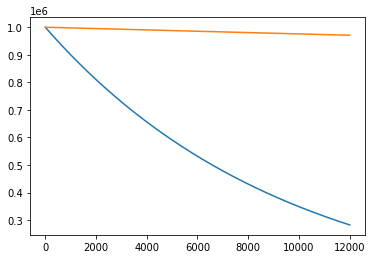

In [1]:
import math
import matplotlib.pyplot as mpl

# Times in seconds
def ActivityAtTime( StartingActivity, TimeElapsed, HalfLife ):
    return StartingActivity * ( 2.0 ** ( -TimeElapsed / HalfLife ) )

def F18ActivityAtTime( StartingActivity, TimeElapsed ):
    return ActivityAtTime( StartingActivity, TimeElapsed, 109.77*60.0 )

def Zr89ActivityAtTime( StartingActivity, TimeElapsed ):
    return ActivityAtTime( StartingActivity, TimeElapsed, 78.41*60.0*60.0 )

def ActivityPlot( StartingActivity, EndTime, ActivityMethod ):
    activityValues = []
    timeValues = []
    time = 0.0
    while time < EndTime:
        activityValues.append( ActivityMethod( StartingActivity, time ) )
        timeValues.append( time )
        time += 1.0
        
    mpl.plot( timeValues, activityValues )
    
ActivityPlot( 1E6, 200.0*60.0, F18ActivityAtTime )
ActivityPlot( 1E6, 200.0*60.0, Zr89ActivityAtTime )
mpl.show()

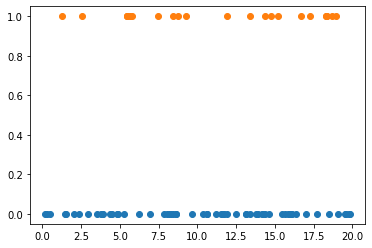

In [2]:
import random

# Simulate poisson-distributed random decay times
# Based on example https://timeseriesreasoning.com/contents/poisson-process/
def ActivityTimeline( DecayRate, EndTime ):
    decayTimes = []
    time = 0.0
    while time < EndTime:
        randUniform = random.random()
        deltaT = -math.log( 1.0 - randUniform ) / DecayRate
        time += deltaT
        if time < EndTime:
            decayTimes.append( time )
            
    return decayTimes
            
def TimelinesPlot( Timelines ):
    for i, decayTimes in enumerate( Timelines ):
        dummyY = []
        for time in decayTimes:
            dummyY.append( i )
            
        mpl.scatter( decayTimes, dummyY )

TimelinesPlot( [ ActivityTimeline( 2, 20 ), ActivityTimeline( 1, 20 ) ] )
mpl.show()

[1.9012566601213194, 2.415680615087507, 3.7474258811632635, 1.237857540458879, 1.2307946554224987]  min =  1.2307946554224987
testing 0 1.9012566601213194  against  1.2307946554224987
coincidence!
testing 1 2.415680615087507  against  1.2307946554224987
testing 2 3.7474258811632635  against  1.2307946554224987
testing 3 1.237857540458879  against  1.2307946554224987
coincidence!
testing 4 1.2307946554224987  against  1.2307946554224987
coincidence!
[6.3656805665993845, 2.415680615087507, 3.7474258811632635, 2.993425987171527, 11.397439943052671]  min =  2.415680615087507
testing 0 6.3656805665993845  against  2.415680615087507
testing 1 2.415680615087507  against  2.415680615087507
coincidence!
testing 2 3.7474258811632635  against  2.415680615087507
testing 3 2.993425987171527  against  2.415680615087507
coincidence!
testing 4 11.397439943052671  against  2.415680615087507
[6.3656805665993845, 5.847817514536864, 3.7474258811632635, 3.9324638611156133, 11.397439943052671]  min =  3.747

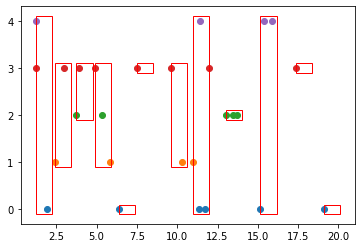

[[0, 3, 4], [1, 3], [2, 3], [1, 2, 3], [0], [3], [1, 3], [0, 0, 1, 3, 4], [2, 2, 2], [0, 4, 4], [3], [0]]


In [32]:
import sys
from matplotlib.patches import Rectangle

def FindCoincidences( Timelines, TimeWindow ):
    coincidences = []
    coincidenceTimes = []
    
    # Find the first event in each timeline
    nextTimes = []
    nextIndices = []
    for decayTimes in Timelines:
        if len( decayTimes ) == 0:
            nextTimes.append( sys.float_info.max )
        else:
            nextTimes.append( decayTimes[0] )
        nextIndices.append( 0 )
    
    unfinishedTimeline = True
    while unfinishedTimeline:

        # Start the window at the first unprocessed event
        time = min( nextTimes )
        print( nextTimes, " min = ", time )
    
        # Find all events in the window
        coincidence = []
        for timelineIndex, nextTime in enumerate( nextTimes ):
            print( "testing", timelineIndex, nextTime, " against ", time )
            if nextTime >= time and nextTime <= time + TimeWindow \
                and nextTime < sys.float_info.max - TimeWindow: # to catch the dummy values
                print( "coincidence!" )
                coincidence.append( timelineIndex )
                
        # Catch a no-coincidence (including self) because we've ended up all infinities
        if len( coincidence ) == 0:
            break
    
        # Update to the next time for anything in the coincidence window
        unfinishedTimeline = False
        finalCoincidence = []
        for timelineIndex in coincidence:
            
            # Find the first time that's outside the current window
            nextIndex = nextIndices[ timelineIndex ]
            nextTime = Timelines[ timelineIndex ][ nextIndex ]
            while nextTime <= time + TimeWindow:
                
                # Add entries if there is coincidence within the window for a single timeline
                finalCoincidence.append( timelineIndex )
                nextIndex += 1
            
                # Test for reaching the end of the timeline
                if nextIndex >= len( Timelines[ timelineIndex ] ):
                    nextTimes[ timelineIndex ] = sys.float_info.max
                    nextIndices[ timelineIndex ] = -1
                    break
                else:
                    nextTime = Timelines[ timelineIndex ][ nextIndex ]
                    nextTimes[ timelineIndex ] = nextTime
                    nextIndices[ timelineIndex ] = nextIndex
                    unfinishedTimeline = True
        
        # Need to search for dummy indices since we don't update everything each round
        for nextIndex in nextIndices:
            if nextIndex > -1:
                unfinishedTimeline = True
                break
                
        coincidences.append( finalCoincidence )
        coincidenceTimes.append( time )
    
    return coincidences, coincidenceTimes

def CoincidenceBoxes( Coincidences, CoincidenceTimes, TimeWindow ):
    
    for i, coincidence in enumerate( Coincidences ):
        time = CoincidenceTimes[ i ]
        y = min( coincidence )
        height = max( coincidence ) - y
        y -= 0.1
        height += 0.2
        mpl.gca().add_patch( Rectangle( (time, y), TimeWindow, height, \
                                        linewidth=1,edgecolor='r',facecolor='none') )
        
exampleTimelines = [ ActivityTimeline( 0.2, 20 ), ActivityTimeline( 0.2, 20 ), ActivityTimeline( 0.2, 20 ), ActivityTimeline( 0.2, 20 ), ActivityTimeline( 0.2, 20 ) ]
coincidences, coincidenceTimes = FindCoincidences( exampleTimelines, 1 )
TimelinesPlot( exampleTimelines )
CoincidenceBoxes( coincidences, coincidenceTimes, 1 )
mpl.show()

print( coincidences )